# Loading and Pre-processing

In [2]:
import tensorflow as tf
print(tf.__version__)

import csv
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras import backend as K
STOPWORDS = set(stopwords.words('english'))

2.7.0


In [2]:
vocab_size = 5000  # most common 5k words
embedding_dim = 64  # 
max_length = 200   # padding length
trunc_type = 'post'   # trunciate from the back
padding_type = 'post'   # pad from the back
oov_tok = '<OOV>'   # tokens used for words that are in word_index
training_portion = .8    # 80-20 split

In [3]:
articles = []
labels = []

# pre-shuffled in excel
# removing stopwords in the meantime
# split labels and descriptions

with open("NUS_training_desc.csv", encoding = 'unicode_escape') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        labels.append(row[0])
        article = row[1]
        for word in STOPWORDS:
            token = ' ' + word + ' '
            article = article.replace(token, ' ')
            article = article.replace(' ', ' ')
        articles.append(article)
print(len(labels))
print(len(articles))

3165
3165


In [4]:
# print(articles)

In [5]:
train_size = int(len(articles) * training_portion)

train_articles = articles[0: train_size]
train_labels = labels[0: train_size]

validation_articles = articles[train_size:]
validation_labels = labels[train_size:]

print(train_size)
print(len(train_articles))
print(len(train_labels))
print(len(validation_articles))
print(len(validation_labels))

2532
2532
2532
633
633


In [6]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_articles)
word_index = tokenizer.word_index
# dict(list(word_index.items())[0:10])

In [7]:
train_sequences = tokenizer.texts_to_sequences(train_articles)

In [8]:
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [9]:
validation_sequences = tokenizer.texts_to_sequences(validation_articles)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

print(len(validation_sequences))
print(validation_padded.shape)

633
(633, 200)


In [ ]:
# print(set(labels))

In [11]:
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(labels)

# expected to be in numpy array
training_label_seq = np.array(label_tokenizer.texts_to_sequences(train_labels))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(validation_labels))

In [12]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_article(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

## Building NLP LSTM model 

In [13]:
model = tf.keras.Sequential([
    # Add an Embedding layer expecting input vocab of size 5000, and output embedding dimension of size 64 we set at the top
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    # use ReLU in place of tanh function since they are very good alternatives of each other.
    tf.keras.layers.Dense(embedding_dim),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Activation('relu'),
    # Add a Dense layer with 68 units and softmax activation.
    # When we have multiple outputs, softmax convert outputs layers into a probability distribution.
    tf.keras.layers.Dense(68, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          320000    
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
activation (Activation)      (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 68)                4420      
Total params: 398,724
Trainable params: 398,724
Non-trainable params: 0
__________________________________________________

In [14]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['sparse_categorical_accuracy', 'accuracy'])

In [15]:
num_epochs = 30
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(train_padded, training_label_seq, epochs=num_epochs, callbacks=[es_callback], validation_data=(validation_padded, validation_label_seq), verbose=2, shuffle=True)

Train on 2532 samples, validate on 633 samples
Epoch 1/30
2532/2532 - 22s - loss: 4.2149 - sparse_categorical_accuracy: 0.0170 - accuracy: 0.0170 - val_loss: 4.1771 - val_sparse_categorical_accuracy: 0.0332 - val_accuracy: 0.0332
Epoch 2/30
2532/2532 - 17s - loss: 3.9990 - sparse_categorical_accuracy: 0.0355 - accuracy: 0.0355 - val_loss: 3.7809 - val_sparse_categorical_accuracy: 0.0316 - val_accuracy: 0.0316
Epoch 3/30
2532/2532 - 17s - loss: 3.7095 - sparse_categorical_accuracy: 0.0545 - accuracy: 0.0545 - val_loss: 3.5384 - val_sparse_categorical_accuracy: 0.0695 - val_accuracy: 0.0695
Epoch 4/30
2532/2532 - 17s - loss: 3.4913 - sparse_categorical_accuracy: 0.0731 - accuracy: 0.0731 - val_loss: 3.3805 - val_sparse_categorical_accuracy: 0.0979 - val_accuracy: 0.0979
Epoch 5/30
2532/2532 - 16s - loss: 3.2282 - sparse_categorical_accuracy: 0.1023 - accuracy: 0.1023 - val_loss: 3.2075 - val_sparse_categorical_accuracy: 0.1406 - val_accuracy: 0.1406
Epoch 6/30
2532/2532 - 17s - loss: 2.9

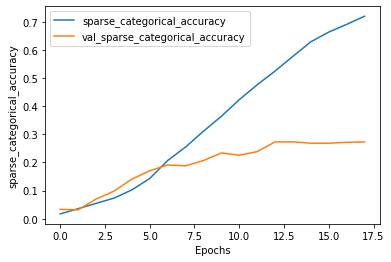

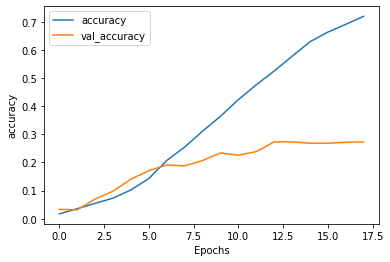

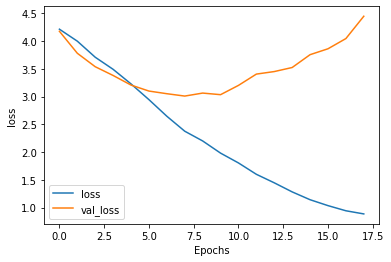

In [16]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
    
plot_graphs(history, "sparse_categorical_accuracy")
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")